# Imports

In [76]:
import essentia
import math
from essentia.standard import *
import matplotlib.pyplot as plt
import pandas as pd

# Loading Samples

In [40]:
tri = essentia.standard.MonoLoader(filename = 'new_samples/Tri_440Hz_Cut_1.wav')
tri1 = essentia.standard.MonoLoader(filename = 'new_samples/Tri+_440Hz_Cut_1.wav')
trisaw = essentia.standard.MonoLoader(filename = 'new_samples/TriSaw_440Hz_Cut_1.wav')
trisaw1 = essentia.standard.MonoLoader(filename = 'new_samples/TriSaw+_440Hz_Cut_1.wav')
saw = essentia.standard.MonoLoader(filename = 'new_samples/Saw_440Hz_Cut_1.wav')

tri_audio = tri().copy()
tri1_audio = tri1().copy()
trisaw_audio = trisaw().copy()
trisaw1_audio = trisaw1().copy()
saw_audio = saw().copy()

sample_dict = {'tri': tri_audio, 'tri+': tri1_audio, 'trisaw': trisaw_audio, 'trisaw+': trisaw1_audio, 'saw': saw_audio}

# Plot of the samples

## Functions

In [88]:
def checkNumOfSamples(*samples):
    for i in range(1, len(samples)):
        if len(samples[i-1]) != len(samples[i]):
            print('sample ' + str(i-1) + ' and ' + str(i) + ' are not the same length')
            return False
        print('samples have the same length')
        return True

def plotSamples(**samples): 
    #Figuring out the number of subplots   
    numSamples = len(samples.keys())
    N = (numSamples/2) if (numSamples%2==0) else (math.floor(numSamples/2)+1)

    fig, axs = plt.subplots(N, 2)
    fig.suptitle('Plot of the Waves (1 Period)')

    i = 0
    j = 0

    for name, sample in samples.items():
        if j == 2:
            j = 0
            i += 1
        axs[i, j].plot(sample)
        axs[i, j].set_title(name)
        j+=1
    fig.tight_layout()


## Cheking if samples have same length

In [50]:
checkNumOfSamples(*sample_dict.items())

samples have the same length


True

## Plotting the audios

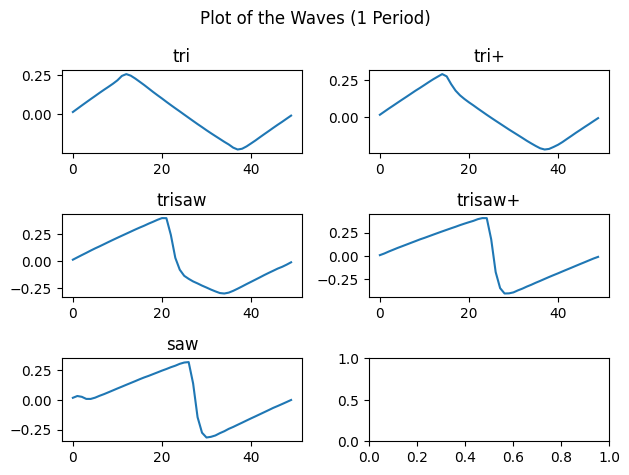

In [89]:
plotSamples(**sample_dict)